https://ai.google.dev/gemma/docs/core/huggingface_text_full_finetune

https://huggingface.co/collections/google/gemma-3-release

https://huggingface.co/datasets/bebechien/MobileGameNPC

In [1]:
import json
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from random import randint
import re

from trl import SFTConfig, SFTTrainer

import matplotlib.pyplot as plt

In [2]:
def create_conversation(sample):
    return {
        "messages": [
            {"role": "user", "content": sample["player"]},
            {"role": "assistant", "content": sample["alien"]},
        ]
    }


npc_type = "martian"

# Load dataset from the Hub
dataset = load_dataset("bebechien/MobileGameNPC", npc_type, split="train")

# Convert dataset to conversational format
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

# Split dataset into 80% training samples and 20% test samples
dataset = dataset.train_test_split(test_size=0.2, shuffle=False)

# Print formatted user prompt
print(json.dumps(dataset["train"][0]["messages"], indent=2))

[
  {
    "content": "Hello there.",
    "role": "user"
  },
  {
    "content": "Gree-tongs, Terran. You'z a long way from da Blue-Sphere, yez?",
    "role": "assistant"
  }
]


In [3]:
base_model = "google/gemma-3-4b-it"
checkpoint_dir = "checkpoints"
learning_rate = 5e-5

In [4]:
# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model, torch_dtype="auto", device_map="auto", attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

`torch_dtype` is deprecated! Use `dtype` instead!
/home/florin/git/FlorinAndrei/gemma3-full-finetune-social-media/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device: cuda:0
DType: torch.bfloat16


In [5]:
# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Load a random sample from the test dataset
rand_idx = randint(0, len(dataset["test"]) - 1)
test_sample = dataset["test"][rand_idx]

# Convert as test example into a prompt with the Gemma template
prompt = pipe.tokenizer.apply_chat_template(
    test_sample["messages"][:1], tokenize=False, add_generation_prompt=True
)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

# Extract the user query and original answer
print(f"Question:\n{test_sample['messages'][0]['content']}\n")
print(f"Original Answer:\n{test_sample['messages'][1]['content']}\n")
print(f"Generated Answer (base model):\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Device set to use cuda:0


Question:
It's raining.

Original Answer:
Gah! Da zky iz leaking again! Zorp will be in da zhelter until it ztopz being zo... wet. Diz iz no good for my jointz.

Generated Answer (base model):
That's a lovely, cozy feeling! Rainy days are great for reading, drinking tea, or just relaxing. 

Do you want to talk about it? Would you like me to:

*   Tell you a rainy day fact?
*   Suggest a rainy day activity?


In [6]:
torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,  # directory to save and repository id
    max_length=512,  # max sequence length for model and packing of the dataset
    packing=False,  # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=5,  # number of training epochs
    per_device_train_batch_size=1,  # batch size per device during training
    gradient_checkpointing=False,  # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",  # use fused adamw optimizer
    logging_steps=1,  # log every step
    save_strategy="epoch",  # save checkpoint every epoch
    eval_strategy="epoch",  # evaluate checkpoint every epoch
    learning_rate=learning_rate,  # learning rate
    fp16=True if torch_dtype == torch.float16 else False,  # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",  # use constant learning rate scheduler
    push_to_hub=False,  # do not push model to hub
    report_to="tensorboard",  # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False,  # Template with special tokens
        "append_concat_token": True,  # Add EOS token as separator token between examples
    },
)

In [7]:
# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Tokenizing train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [8]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,3.249200,2.976813,2.378411,1038.000000,0.472527
2,2.670900,3.347017,1.774477,2076.000000,0.439560
3,0.876400,3.945431,1.167023,3114.000000,0.454212
4,0.553000,3.873558,1.457550,4152.000000,0.421245
5,0.521100,4.100466,1.359431,5190.000000,0.417582


TrainOutput(global_step=100, training_loss=1.4228232929483056, metrics={'train_runtime': 202.6875, 'train_samples_per_second': 0.493, 'train_steps_per_second': 0.493, 'total_flos': 112854735576000.0, 'train_loss': 1.4228232929483056, 'epoch': 5.0})

In [9]:
# Save the final model again to the Hugging Face Hub
trainer.save_model()

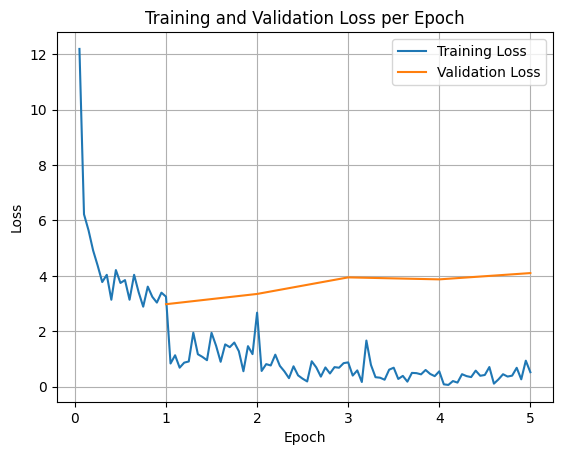

In [10]:
# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
del model, tokenizer, pipe, trainer
torch.cuda.empty_cache()

In [12]:
model_id = checkpoint_dir

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_id, torch_dtype="auto", device_map="auto", attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)


def test(test_sample):
    # Convert as test example into a prompt with the Gemma template
    prompt = pipe.tokenizer.apply_chat_template(
        test_sample["messages"][:1], tokenize=False, add_generation_prompt=True
    )
    outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

    # Extract the user query and original answer
    print(f"Question:\n{test_sample['messages'][0]['content']}")
    print(f"Original Answer:\n{test_sample['messages'][1]['content']}")
    print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")
    print("-" * 80)


# Test with an unseen dataset
for item in dataset['test']:
    test(item)

Device set to use cuda:0


Question:
Do you know any jokes?
Original Answer:
A joke? k'tak Yez. A Terran, a Glarzon, and a pile of nutrient-pazte walk into a bar... Narg, I forget da rezt. Da punch-line waz zarcaztic.
Generated Answer:
Gree-tongs, You'z a long way from da Blue-Sphere, yez?
--------------------------------------------------------------------------------
Question:
(Stands idle for too long)
Original Answer:
You'z broken, Terran? Or iz diz... 'meditation'? You look like you're trying to lay an egg.
Generated Answer:
Too high? k'tak Diz technology iz billionz of your mile from its home! You pay for zhipping!
--------------------------------------------------------------------------------
Question:
What do you think of my outfit?
Original Answer:
Iz very... pointy. Are you expecting to be attacked by zky-eelz? On Marz, dat would be zenzible.
Generated Answer:
My outfit? My outfit iz da Outpozt. A tiny piece of da Red-Dust on your... k'tak... very green world.
-----------------------------------------